# Dependencies

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [10]:
masks = ["S2CLOUDLESS", "SENSEIV2", "SCOREPLUS", "UNETMOBV2", "SEN2COR", "FMASK", "KAPPAMASK"]

dataset_path = "../data/CloudSEN12+"

for MASK in masks:
    raw_df = pd.read_csv(f"{dataset_path}/raw_data.csv")
    masked_df = pd.DataFrame()
    if MASK == "SENSEIV2":
        masked_df = pd.read_csv(f"{dataset_path}/masked_data_senseiv2.csv", index_col=0)
    elif MASK == "SCOREPLUS":
        masked_df = pd.read_csv(f"{dataset_path}/masked_data_scoreplus.csv", index_col=0)
    elif MASK == "S2CLOUDLESS":
        masked_df = pd.read_csv(f"{dataset_path}/masked_data_s2cloudless.csv", index_col=0)
    elif MASK == "UNETMOBV2":   
        masked_df = pd.read_csv(f"{dataset_path}/masked_data_unetmobv2.csv", index_col=0)
    elif MASK == "SEN2COR":
        masked_df = pd.read_csv(f"{dataset_path}/masked_data_sen2cor.csv", index_col=0)
    elif MASK == "FMASK":
        masked_df = pd.read_csv(f"{dataset_path}/masked_data_fmask.csv", index_col=0)
    elif MASK == "KAPPAMASK":
        masked_df = pd.read_csv(f"{dataset_path}/masked_data_kappamask.csv", index_col=0)


    # Concatenate the DataFrames side by side
    merged_df = pd.merge(raw_df, masked_df, on="name")
    # Calculate differences
    merged_df['R_entropy_diff'] = merged_df['raw_R_entropy'] - merged_df['masked_R_entropy']
    merged_df['G_entropy_diff'] = merged_df['raw_G_entropy'] - merged_df['masked_G_entropy']
    merged_df['B_entropy_diff'] = merged_df['raw_B_entropy'] - merged_df['masked_B_entropy']
    merged_df['total_objects_diff'] = merged_df['masked_total_objects'] - merged_df['raw_total_objects']

    # Calculate delta NO
    merged_df['delta_no'] = np.where(
        merged_df['raw_total_objects'] != 0,
        (merged_df['total_objects_diff'] / merged_df['raw_total_objects']) * 100,
        0
    )

    # Save the side-by-side DataFrame to a CSV file
    if MASK == "SENSEIV2":
        merged_df.to_csv(f"{dataset_path}/merged_raw_senseiv2_data.csv", index=False)
    elif MASK == "SCOREPLUS":
        merged_df.to_csv(f"{dataset_path}/merged_raw_scoreplus_data.csv", index=False)
    elif MASK == "S2CLOUDLESS":
        merged_df.to_csv(f"{dataset_path}/merged_raw_s2cloudless_data.csv", index=False) 
    elif MASK == "UNETMOBV2":
        merged_df.to_csv(f"{dataset_path}/merged_raw_unetmobv2_data.csv", index=False)
    elif MASK == "SEN2COR":
        merged_df.to_csv(f"{dataset_path}/merged_raw_sen2cor_data.csv", index=False)
    elif MASK == "FMASK":
        merged_df.to_csv(f"{dataset_path}/merged_raw_fmask_data.csv", index=False)
    elif MASK == "KAPPAMASK":
        merged_df.to_csv(f"{dataset_path}/merged_raw_kappamask_data.csv", index=False)

    merged_df

# Results

CloudSEN12+ consists of different regions of interest (ROIs) with five scenarios: cloud-free (0%), almost clear (0–25%), low-cloudy (25–65%), mid-cloudy (45–65%), and cloudy image (>65%). In this analysis, we utilized all scenarios.

In [11]:
dataset_path = "../data/CloudSEN12+"

algorithms = [
    "senseiv2",
    "s2cloudless",
    "scoreplus",
    "unetmobv2",
    "sen2cor",
    "fmask",
    "kappamask"
]

masks_data = [
    {
        "name": algorithm.upper(),
        "merged_df": pd.read_csv(f"{dataset_path}/merged_raw_{algorithm}_data.csv")
    }
    for algorithm in algorithms
]

## Comparison of detected objects in raw versus cloud-masked images - Figure 4 of the Article

Delta NO for SENSEIV2: 95.681%
Delta NO for S2CLOUDLESS: 27.158%
Delta NO for SCOREPLUS: 35.374%
Delta NO for UNETMOBV2: 92.267%
Delta NO for SEN2COR: 23.058%
Delta NO for FMASK: 18.989%
Delta NO for KAPPAMASK: 12.010%


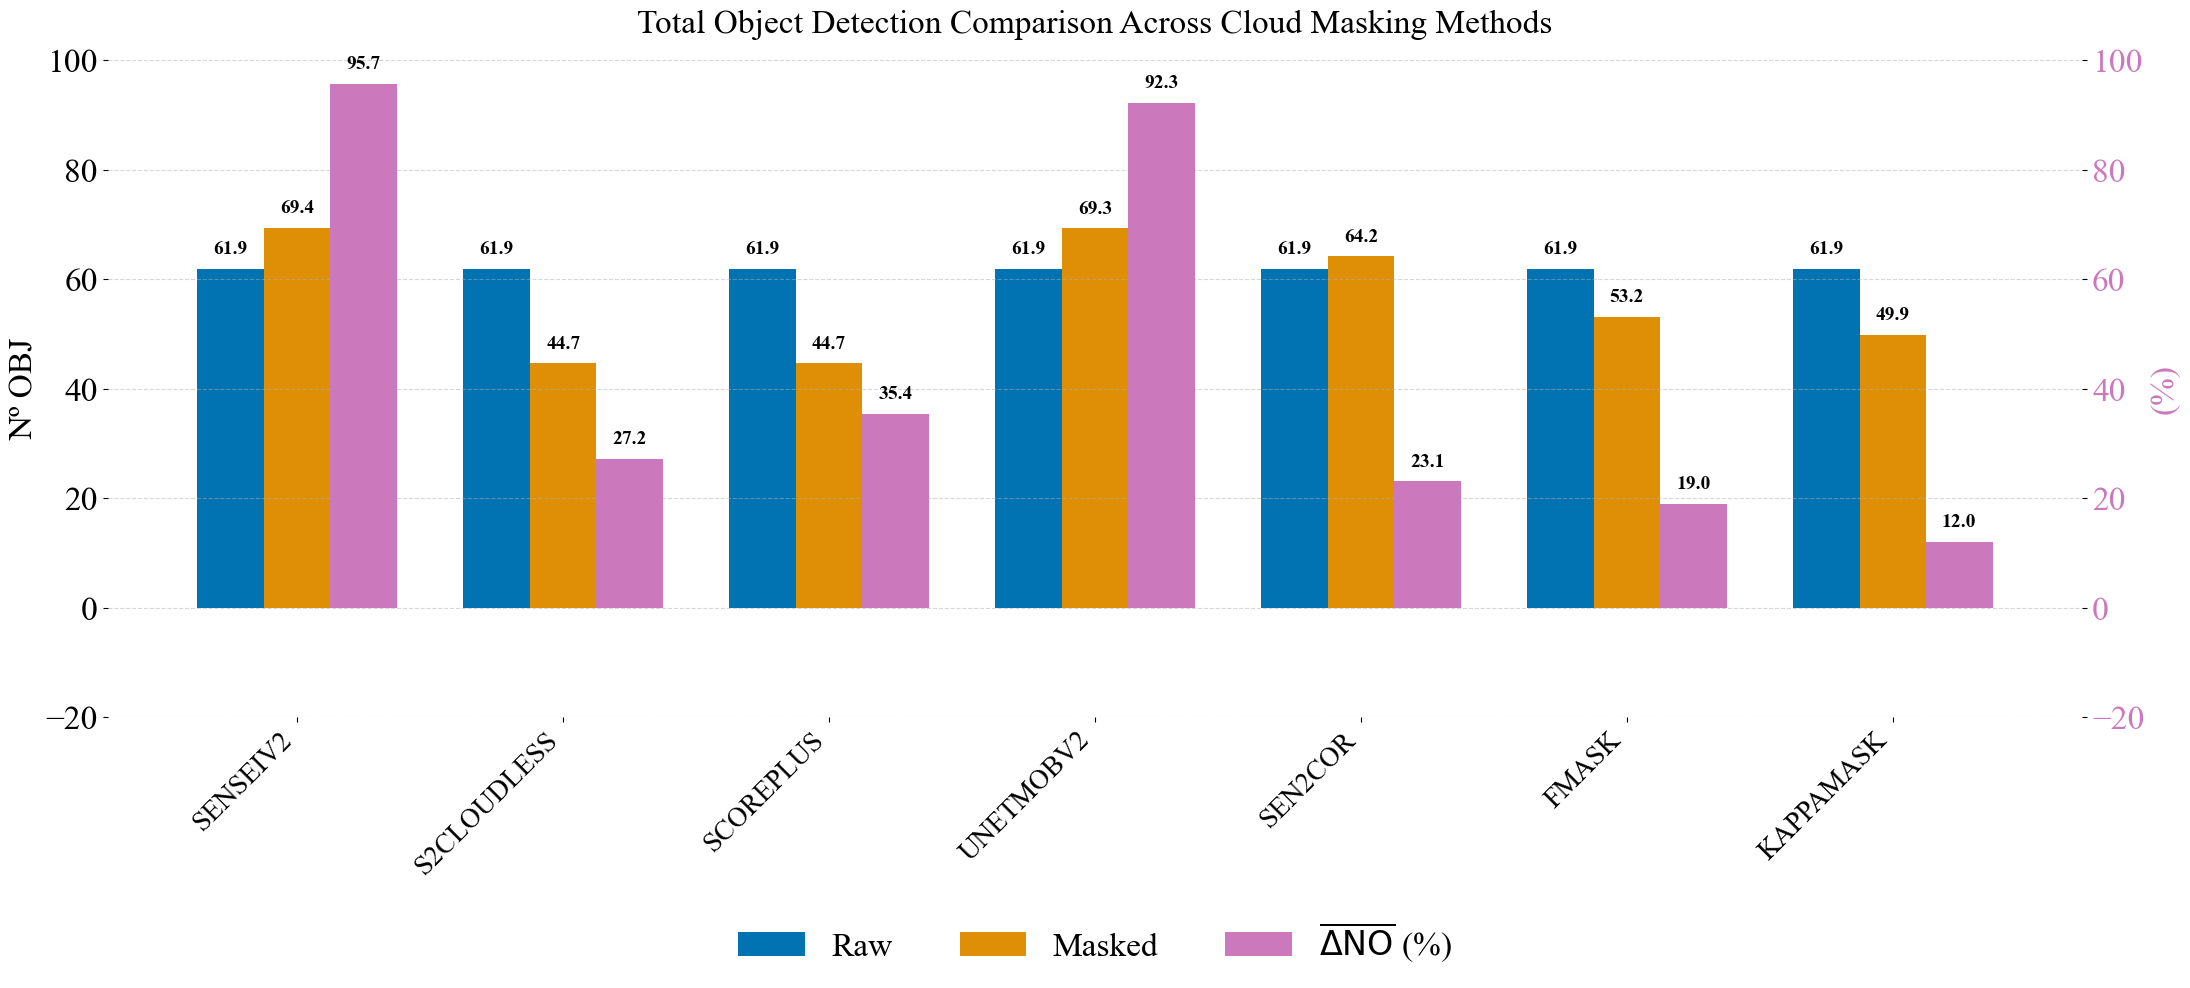

In [12]:
plt.rcParams['font.family'] = 'Times New Roman'
palette = sns.color_palette("colorblind")

methods_summary = []
for method in masks_data:
    algorithm_name = method["name"]
    merged_df = method["merged_df"]
    filtered_df = merged_df[(merged_df['cloud_percentage'] > 10) & (merged_df['cloud_percentage'] < 90)]
    methods_summary.append({
        'Method': algorithm_name,
        'Raw': filtered_df['raw_total_objects'].mean(),
        'Masked': filtered_df['masked_total_objects'].mean(),
        'ΔNO per image': filtered_df['delta_no'].mean()
    })

    print(f"Delta NO for {algorithm_name}: {filtered_df['delta_no'].mean():.3f}%")

summary_df = pd.DataFrame(methods_summary)
x = np.arange(len(summary_df))
width = 0.25  # Slightly wider now that we have only 3 bars

fig, ax1 = plt.subplots(figsize=(22, 10))
ax2 = ax1.twinx()

# Set y-axis limits
ax1.set_ylim(-20, 100)
ax2.set_ylim(-20, 100)

# Bars: only Raw, Masked, and ΔNO per image
bars_raw = ax1.bar(
    x - width, summary_df['Raw'], width,
    label='Raw', color=palette[0]
)
bars_masked = ax1.bar(
    x, summary_df['Masked'], width,
    label='Masked', color=palette[1]
)

bars_delta_no = ax2.bar(
    x + width, summary_df['ΔNO per image'], width,
    label=r'$\overline{\Delta \mathrm{NO}}$ (%)', color=palette[4]
)

# Add value labels
def add_value_labels(ax, bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2., height + (0.02 * ax.get_ylim()[1]),
                f"{height:.1f}", ha='center', va='bottom',
                fontsize=14, fontweight='bold', color='black')

add_value_labels(ax1, bars_raw)
add_value_labels(ax1, bars_masked)
add_value_labels(ax2, bars_delta_no)

# Formatting axes
ax1.set_ylabel('Nº OBJ', fontsize=24)
ax2.set_ylabel('(%)', fontsize=24, color=palette[4])
ax1.tick_params(axis='y', labelsize=24)
ax2.tick_params(axis='y', labelsize=24, labelcolor=palette[4])

# X-axis formatting
ax1.set_xticks(x)
ax1.set_xticklabels(summary_df['Method'], rotation=45, ha='right', fontsize=20)

# Title and grid
ax1.set_title('Total Object Detection Comparison Across Cloud Masking Methods', fontsize=24, pad=20)
ax1.grid(True, axis='y', linestyle='--', alpha=0.5)

# Remove spines
for spine in ax1.spines.values():
    spine.set_visible(False)
for spine in ax2.spines.values():
    spine.set_visible(False)

# Combined legend
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
fig.legend(handles1 + handles2, labels1 + labels2, 
           loc='lower center', ncol=3, fontsize=24, 
           frameon=False, bbox_to_anchor=(0.5, 0))

plt.tight_layout(rect=[0, 0.1, 1, 1])
# plt.savefig("Figure4.png", dpi=300)
plt.show()


## Confusion Matrix metrics and Novel Metrics plot -> Figure 6 of the Article

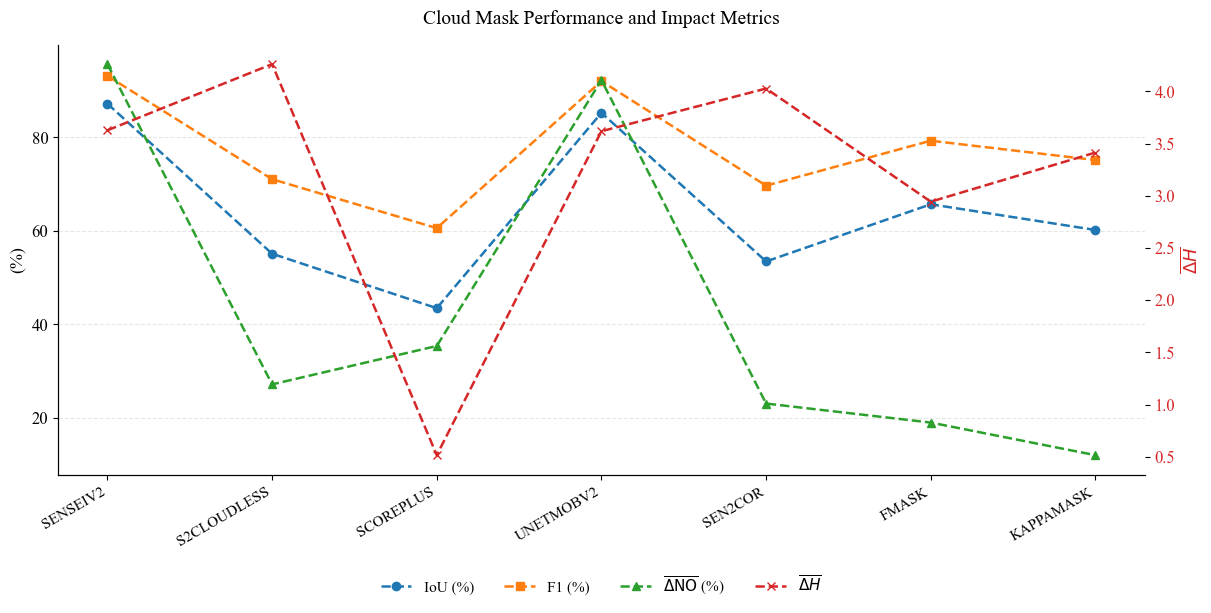

In [13]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12  # slightly smaller font to match smaller figure

# Prepare data
plot_metrics = []

for method in masks_data:
    algorithm = method['name']
    merged_df = method['merged_df']
    metrics_df = pd.read_csv(f"{dataset_path}/metrics_cm_{algorithm.lower()}.csv")

    filtered_df = merged_df[
        (merged_df['cloud_percentage'] > 10) & (merged_df['cloud_percentage'] < 90)
    ]

    iou = metrics_df.loc[metrics_df['Class'] == 'Thick Cloud', 'IoU'].values[0] * 100
    f1 = metrics_df.loc[metrics_df['Class'] == 'Thick Cloud', 'F1 Score'].values[0] * 100
    hr = metrics_df.loc[metrics_df['Class'] == 'Mean Entropy R', 'F1 Score'].values[0]
    hg = metrics_df.loc[metrics_df['Class'] == 'Mean Entropy G', 'F1 Score'].values[0]
    hb = metrics_df.loc[metrics_df['Class'] == 'Mean Entropy B', 'F1 Score'].values[0]

    plot_metrics.append({
        'Method': algorithm,
        'IoU (%)': iou,
        'F1 (%)': f1,
        r'$\overline{\Delta \mathrm{NO}}$ (%)': filtered_df['delta_no'].mean(),
        r'$\overline{\Delta H}(R)$': filtered_df['raw_R_entropy'].mean() - hr,
        r'$\overline{\Delta H}(G)$': filtered_df['raw_G_entropy'].mean() - hg,
        r'$\overline{\Delta H}$': filtered_df['raw_B_entropy'].mean() - hb,
    })

plot_df = pd.DataFrame(plot_metrics)
methods = plot_df['Method']

left_metrics = ['IoU (%)', 'F1 (%)', r'$\overline{\Delta \mathrm{NO}}$ (%)']
right_metric = r'$\overline{\Delta H}$'

x = np.arange(len(methods))

# Create smaller figure
fig, ax1 = plt.subplots(figsize=(12, 6), constrained_layout=True)
ax2 = ax1.twinx()

# Paleta de cores
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
markers = ['o', 's', '^', 'x']  # símbolos diferentes

# Plot left y-axis metrics
for i, metric in enumerate(left_metrics):
    ax1.plot(
        x, plot_df[metric],
        marker=markers[i], linestyle='--', label=metric, color=colors[i],
        markersize=6, linewidth=1.8
    )

# Plot right y-axis metric (entropy)
ax2.plot(
    x, plot_df[right_metric],
    marker=markers[3], linestyle='--', label=right_metric, color=colors[3],
    markersize=6, linewidth=1.8
)

# Formatting
ax1.set_xticks(x)
ax1.set_xticklabels(methods, rotation=30, ha='right', fontsize=11)
ax1.tick_params(axis='y', labelsize=12)
ax2.tick_params(axis='y', labelsize=12)
ax1.set_ylabel('(%)', fontsize=13)
ax2.set_ylabel(r'$\overline{\Delta H}$', fontsize=13, color=colors[3])
ax2.tick_params(axis='y', labelcolor=colors[3])
ax1.set_title('Cloud Mask Performance and Impact Metrics', fontsize=14, pad=15)
ax1.grid(axis='y', linestyle='--', alpha=0.3)
sns.despine()

# Legends (merged from both axes)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(
    lines1 + lines2, labels1 + labels2,
    loc='upper center', ncol=4, fontsize=11, frameon=False,
    bbox_to_anchor=(0.5, -0.2)  # closer to x-axis
)

# Save without cropping
# plt.savefig("Figure5.png", dpi=300, bbox_inches="tight")
plt.show()
